In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PlotSettings import MainColor1, MainColor2, MainColor3, BackgroundColor3, BackgroundColor1, BackgroundColor2, Gray1, Gray2
from CrossSections import  sigmaV_to_ZZ_Approx, Transfer_sigma
from Constants import DensityFactor, Mp, mm

from scipy.integrate import quad, odeint
from scipy import misc, special, optimize

import matplotlib.patches as mpatches




/tmp/ipykernel_21284/2296133727.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


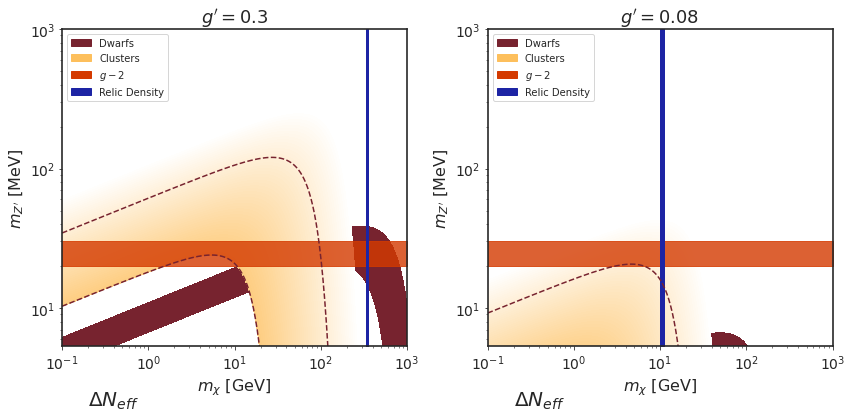

In [2]:
gp_l = (0.3, 8e-2)  

g_p = 200 #Grid Points
M_l = np.logspace(np.log10(5.3), 3, g_p)
m_l = np.logspace(-1, 3, g_p)

#Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))

n = 50
levels_dw=[10, 70]
levels_cl= np.logspace(-3, 0.1, n+1)  # Generate logarithmically spaced values
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.ravel()

#Colors
clusterColors = BackgroundColor2
DwColors =BackgroundColor1
Muoncolors = MainColor3
RelicColors = MainColor1


fig_index = 0

patch_dw = mpatches.Patch(color=DwColors, label=r'Dwarfs')
patch_cl = mpatches.Patch(color=clusterColors, label=r'Clusters')
patch_g2 = mpatches.Patch(color=Muoncolors, label=r'$g-2$')
patch_Oh2 = mpatches.Patch(color=RelicColors, label=r'Relic Density')

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(c1)
    c2=np.array(c2)
    return (1-mix)*c1 + mix*c2

c2 = clusterColors  # yellow
c1 = (1, 1, 1)  # white
clf = [colorFader(c1, c2, (np.log10(l) + 3)/4) for l in levels_cl]

for g in gp_l:
    
    for i in range(g_p):
        for j in range(g_p):
            sigma_grid_dwarf[i, j] = Transfer_sigma(30, g, M_l[j], m_l[i])
            sigma_grid_clusters[i, j] = Transfer_sigma(1000, g, M_l[j], m_l[i])

    ax[fig_index].set_title('$g^{{\prime}} = {}$'.format(g))
    
    ax[fig_index].contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=(DwColors,))
    ax[fig_index].contourf(m_g, M_g, sigma_grid_clusters, levels_cl, colors=clf)
    ax[fig_index].contour(m_g, M_g, sigma_grid_clusters, [0.01, levels_cl[-1] ], colors=(DwColors,), linestyles='dashed')
    
    ax[fig_index].fill_between(m_l, y1=20, y2=30, color=Muoncolors, alpha=0.8)
    ax[fig_index].text(0.2, 2, r'$\Delta N_{eff}$', fontsize=20)    
    #ax[fig_index].fill_between(m_l, M_l[0], 5.3, color=Gray1, alpha=0.6) 
    ax[fig_index].set_xlabel('$m_{\chi} ~[\mathrm{GeV} ]$' )
    ax[fig_index].set_ylabel('$m_{Z\'} ~[\mathrm{MeV} ]$' )
    ax[fig_index].set_xscale('log')
    ax[fig_index].set_yscale('log')
    ax[fig_index].legend(handles=[patch_dw, patch_cl, patch_g2, patch_Oh2], loc='upper left')

    fig_index +=1


#Relic Density
ax[0].fill_between(([330, 350]), y1=M_l[0], y2=M_l[-1], color=RelicColors)
ax[1].fill_between(([10, 11]), y1=M_l[0], y2=M_l[-1], color=RelicColors)


fig.tight_layout()
fig.show()
fig.savefig("Plots/ParameterSpacePlot.pdf")
fig.savefig("Plots/ParameterSpacePlot.svg")

In [3]:


#Grid
g_p = 10
M_l = np.logspace(-3, 1, g_p)
g_l = np.logspace(-4, -1, g_p)
g_g, M_g = np.meshgrid(g_l, M_l)


""" 
Functions  //////////////////////////
"""

#### g - 2

#Functions
def integral(m):
    return quad(lambda x: mm**2*x**2*(1-x)/(x**2*mm**2 + (1-x)*m**2), 0, 1)[0]

def Delta_a(g, M, charge):    
    return g**2*charge/(4*np.pi**2) * integral(M)

#Delta a grid
def Delta_grid(charges):
    Da_grid = np.zeros((g_p, g_p))
    for i in range(g_p):
        for j in range(g_p):
            Da_grid[i, j] = Delta_a(g_l[j], M_l[i], charges[0])
    return Da_grid



#### Relic density

def gs_to_half(T):
    a, b, c = 10.2, 2.349, 0.252
    return a/(1 + np.exp( -b*(T - c)))

def Yeq(x):
    return 0.145*x**1.5*np.exp(-x)

X =np.logspace(np.log10(1),np.log10(100), int(1e4))

def dYdx(Y, x, σv, m):
    return - np.sqrt(np.pi*Mp**2/45) * gs_to_half(m/x)/x**2 * (Y**2-Yeq(x)**2) * m * σv

def Y(x, g, M, m):
    σv = sigmaV_to_ZZ_Approx(g, M, m)
    return odeint(dYdx, Yeq(x[0]), x, args=(σv, m))


def Log_Omega_h2(m):
    Oh2_g = np.zeros((g_p, g_p))
    for i in range(g_p):
        for j in range(g_p):
            Oh2_g[i,j] = Y(X, g_l[j], M_l[i], m)[-1,0]
    LogDF = np.log10(DensityFactor)
    return np.log10(Oh2_g*m) + LogDF



"""
Importing data on constrains //////////////////////////
"""

# BaBar
BaBar_data = np.loadtxt("Data-Sets/Babar_exclusion.csv", delimiter=',')
Babar_x = BaBar_data[:,0]
Babar_y = BaBar_data[:,1]

# CCFR
CCFR_data = np.loadtxt("Data-Sets/Nu-trident_exclusion.csv", delimiter=',') 
CCFR_x = CCFR_data[:,0]
CCFR_y = CCFR_data[:,1]



In [4]:
Log_Omega_h2(1e-3)

TypeError: sigmaV_to_ZZ_Approx() takes 2 positional arguments but 3 were given

c:\Users\Nicolás\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\Nicolás\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_5512\1325925883.py:56: RuntimeWarning: invalid value encountered in log10
  return np.log10(Oh2_g*m) + LogDF
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_5512\1325925883.py:56: RuntimeWarning: divide by zero encountered in log10
  return np.log10(Oh2_g*m) + LogDF
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_5512\3075101896.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a 

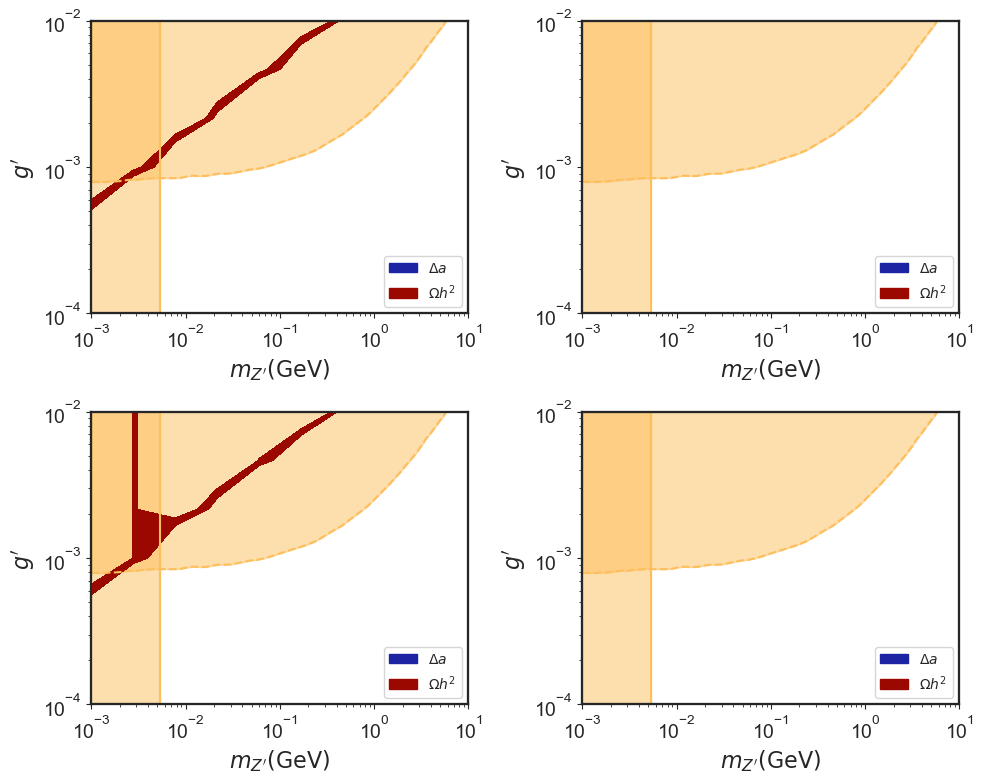

In [ ]:

"""
Plotting Functions ///////////////////////////////////
"""

# Parameters for the plots

m_chi = [1e-3, 5e-1, 2e-2, 3]
Qs = [(1, 1), (1, 1), (0.6, 0.8), (0.6, 0.8)] 


#### Parameter space plot

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax = ax.ravel()

delta_a_minus = (259 - 2*51)*1e-11
delta_a_plus = (259 + 2*51)*1e-11

levels_a = [delta_a_minus, delta_a_plus]
levels_d = [np.log10(0.1), np.log10(0.16)]


patch_a = mpatches.Patch(color=MainColor1, label=r'$\Delta a $')
patch_d = mpatches.Patch(color=MainColor2, label=r'$ \Omega h^2 $')


for fig_index in range(4):
    #ax[fig_index].text(2, 2e-4, r'$m_{{\chi}} = {}, Q_{{ \mu}} = {}, \n Q_{{\chi}} = {}$'.format(m_chi[fig_index],Qs[fig_index][0], Qs[fig_index][1]), fontsize=10)
    ax[fig_index].set_xlabel('$m_{Z\'} (\mathrm{GeV} )$' )
    ax[fig_index].set_ylabel('$g\'$')
    ax[fig_index].set_xscale('log')
    ax[fig_index].set_yscale('log')
    ax[fig_index].set_ylim(1e-4, 1e-2)
    ax[fig_index].set_xlim(1e-3, 1e1)

    # Plot exclusion regions
    ColorConstraints = BackgroundColor2
    ax[fig_index].plot(CCFR_x, CCFR_y, color=ColorConstraints, linestyle='--')
    ax[fig_index].vlines(x=5.3e-3, ymin=1e-5, ymax=1e-2, colors=ColorConstraints, linestyle='-')
    ax[fig_index].fill_betweenx(g_l, 5.3e-3, color=ColorConstraints, alpha=0.5) 
    ax[fig_index].fill_between(CCFR_x, CCFR_y, g_l[-1], color=ColorConstraints, alpha=0.5) 
    
    #g - 2
    #ax[fig_index].contourf(M_g, g_g, Delta_grid(Qs[fig_index]), levels_a, colors= (MainColor1,))

    #Relic Density
    ax[fig_index].contourf(M_g, g_g, Log_Omega_h2(m_chi[fig_index]), levels_d, colors=(MainColor2,))

    ax[fig_index].legend(handles=[patch_a, patch_d], loc='lower right')

#Plot constrains


fig.tight_layout()
fig.show()




In [ ]:
m = 1e-1
Oh2_g = np.zeros((g_p, g_p))
for i in range(g_p):
    for j in range(g_p):
        Oh2_g[i,j] = Y(x, g_l[j], M_l[i], m)[0][-1]



In [ ]:
for i in range(1):
    Y(x, g_l[3], M_l[i], m)[0][-1]

In [ ]:
M_l[1]

Yield for $M = 1MeV, g'=0.1, m=0.1 GeV$:

In [ ]:


def gs_to_half(T):
    a, b, c = 10.2, 2.349, 0.252
    return a/(1 + np.exp( -b*(T - c)))

def Yeq(x):
    return 0.145*x**1.5*np.exp(-x)

X =np.logspace(np.log10(1),np.log10(100), int(1e6))

def dYdx(Y, x, σv, m):
    return - np.sqrt(np.pi*Mp**2/45) * gs_to_half(m/x)/x**2 * (Y**2-Yeq(x)**2) * m * σv

def Y(x, m, σv):
    
    return odeint(dYdx, Yeq(x[0]), x, args=(σv, m))

def Yinf(m, σv):
    return Y(X, m, σv)[-1,0]

def RelicDensity(m, σv):
    return DensityFactor*Yinf(m, σv)*m




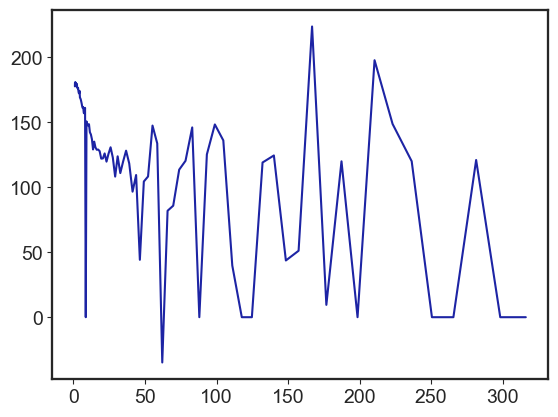

In [ ]:
mDM_array = np.logspace(0, 2.5, 100)
σv = 1e-12
RD_array = [RelicDensity(mDM, σv) for mDM in mDM_array]

plt.plot(mDM_array, RD_array, color=MainColor1)
plt.show()